<h2> Base Model - CNN with 1 Convolutional Layer-Reproducible Results </h2>

In [1]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random

from __future__ import print_function
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import os
from datetime import datetime

Using TensorFlow backend.


In [0]:
#fixed random seed to fix weight initialization to compare results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

optmz = optimizers.Adam(lr=0.001)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
trDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 224, 224, 3), (4264,), (1067, 224, 224, 3), (1067,)


Showing 772 index image, It is 0.0


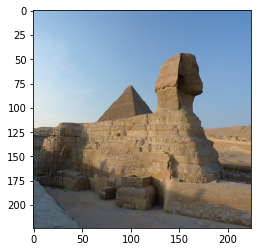

Showing 507 index image, It is 1.0


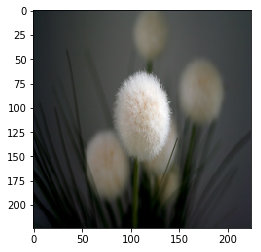

Showing 940 index image, It is 0.0


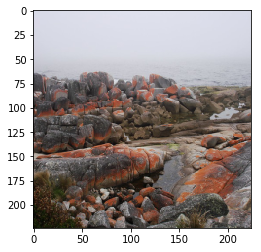

Showing 99 index image, It is 1.0


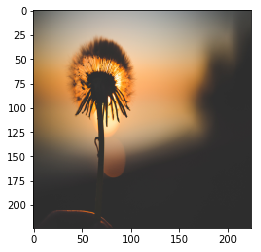

Showing 418 index image, It is 1.0


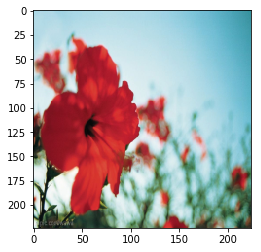

In [5]:
# Randomly show 5 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(5):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg,2)
tsLbl       = to_categorical(tsLblOrg,2)
num_classes = tsLbl.shape[1]

In [0]:
# X_train forms the test images, and y_test forms the test labels
X_train, y_train = trDat, trLbl
X_test,y_test = tsDat,tsLbl 

<h2> Define Model </h2>

<p>The 1st layer is a Conv2D layer for the convolution operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here I choose feature map with size 3 x 3.
  
The 2nd layer is a MaxPooling2D layer for the max-pooling operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here I choose the pooling window with size 2 x 2.
  
The next step is to feed the last output tensor into a stack of Dense layers, otherwise known as fully-connected layers. These densely connected classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. Thus, I need to flatten the 3D outputs to 1D, and then add 2 Dense layers on top.
  
I do a 2-way classification (as there are flowers and non-flowers), using a final layer with 2 outputs and a softmax activation. Softmax activation enables me to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input. <p>

In [8]:
#fixed random seed to fix weight initialization to compare results
#START A NEW TF SESSION
np.random.seed(1)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)


optmz = optimizers.Adam(lr=0.001)
    
def createBaseModel():
  inputs = Input(shape=(imgrows, imgclms, channel))
  x = Conv2D(32, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = Flatten()(x)
      
  x = Dense(128, activation='relu',kernel_initializer='he_normal')(x)
  x = Dense(num_classes, activation='softmax',kernel_initializer='he_normal')(x)
      
  model = Model(inputs=[inputs],outputs=x)
  model.compile(loss='categorical_crossentropy', 
                optimizer=optmz,
                metrics=['accuracy'])
      
  return model
    
model = createBaseModel()
modelGo = createBaseModel()
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 51,381,506
Trainable params: 51,381,506
Non-trainable params: 0
_________________________________________________

<h2> Training the Model </h2>

<p>I train the model with batch size of 64 and 20 epochs on both training and validation data. </p>

In [9]:
# Fit the model
# This is where the training starts
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1)

Epoch 1/20
4264/4264 [==============================] - 10s 2ms/sample - loss: 13.6277 - acc: 0.6710
Epoch 2/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 2.5657 - acc: 0.7840
Epoch 3/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 1.3018 - acc: 0.8469
Epoch 4/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6386 - acc: 0.9069
Epoch 5/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3355 - acc: 0.9386
Epoch 6/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3725 - acc: 0.9327
Epoch 7/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3938 - acc: 0.9379
Epoch 8/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.1027 - acc: 0.9740
Epoch 9/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3674 - acc: 0.9435
Epoch 10/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.0618 - acc: 0.9859
Epoch 1

In [10]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1067/1067 [==============================] - 1s 1000us/sample - loss: 1.2994 - acc: 0.8482
Test loss: 1.299443188178394
Test accuracy: 0.8481724


In [11]:
# Make classification on the test dataset
predicts    = model.predict(X_test)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

# the labels for the classfication report
labelname   = ['flower', 'non-flower']


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

K.clear_session()

Best accuracy (on testing dataset): 84.82%
              precision    recall  f1-score   support

      flower     0.8120    0.8370    0.8243       454
  non-flower     0.8765    0.8564    0.8663       613

    accuracy                         0.8482      1067
   macro avg     0.8442    0.8467    0.8453      1067
weighted avg     0.8490    0.8482    0.8484      1067

[[380  74]
 [ 88 525]]





<h2> Retrain Model to check reproducible results </h2>

<p> To check if same consistency can be achieved </p>

In [12]:
#fixed random seed to fix weight initialization to compare results
#START A NEW TF SESSION
np.random.seed(1)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)


optmz = optimizers.Adam(lr=0.001)
    
def createBaseModel1():
  inputs = Input(shape=(imgrows, imgclms, channel))
  x = Conv2D(32, (3, 3), padding='same', activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = Flatten()(x)
      
  x = Dense(128, activation='relu',kernel_initializer='he_normal')(x)
  x = Dense(num_classes, activation='softmax',kernel_initializer='he_normal')(x)
      
  model1 = Model(inputs=[inputs],outputs=x)
  model1.compile(loss='categorical_crossentropy', 
                optimizer=optmz,
                metrics=['accuracy'])
      
  return model1
    
model1 = createBaseModel()
modelGo1 = createBaseModel()
    
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 51,381,506
Trainable params: 51,381,506
Non-trainable params: 0
_________________________________________________

In [13]:
# Fit the model
# This is where the training starts
history1 = model1.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1)

Epoch 1/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 27.5201 - acc: 0.6280
Epoch 2/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 4.7582 - acc: 0.7458
Epoch 3/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 1.7797 - acc: 0.8314
Epoch 4/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 1.0938 - acc: 0.8593
Epoch 5/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 1.7033 - acc: 0.8473
Epoch 6/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3489 - acc: 0.9468
Epoch 7/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.3429 - acc: 0.9472
Epoch 8/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.1382 - acc: 0.9702
Epoch 9/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.0439 - acc: 0.9890
Epoch 10/20
4264/4264 [==============================] - 8s 2ms/sample - loss: 0.0353 - acc: 0.9916
Epoch 11

In [14]:
score1 = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.6229835400094244
Test accuracy: 0.8453608


In [15]:
# Make classification on the test dataset
predicts1    = model1.predict(X_test)

# Prepare the classification output
# for the classification report
predout1     = np.argmax(predicts1,axis=1)
testout1    = np.argmax(y_test,axis=1)

# the labels for the classfication report
labelname   = ['flower', 'non-flower']


testScores1  = metrics.accuracy_score(testout1,predout1)
confusion1   = metrics.confusion_matrix(testout1,predout1)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores1*100))
print(metrics.classification_report(testout1,predout1,target_names=labelname,digits=4))
print(confusion1)

Best accuracy (on testing dataset): 84.54%
              precision    recall  f1-score   support

      flower     0.8134    0.8260    0.8197       454
  non-flower     0.8696    0.8597    0.8646       613

    accuracy                         0.8454      1067
   macro avg     0.8415    0.8428    0.8422      1067
weighted avg     0.8457    0.8454    0.8455      1067

[[375  79]
 [ 86 527]]


<h2> Retrain with Sequential Model </h2>

In [16]:
#fixed random seed to fix weight initialization to compare results
'''g = tf.Graph()
with g.as_default():
  tf.set_random_seed(1)'''

#fixed random seed to fix weight initialization to compare results
#START A NEW TF SESSION
np.random.seed(1)
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
    
optmz = optimizers.Adam(lr=0.001)
    
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',kernel_initializer='he_normal',input_shape=(imgrows,imgclms,channel),kernel_regularizer=l2(1e-4)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
    
model2.add(Flatten())
    
model2.add(Dense(128,kernel_initializer='he_normal'))
model2.add(Activation('relu'))
model2.add(Dense(num_classes,kernel_initializer='he_normal'))
model2.add(Activation('softmax'))

model2.compile(loss='categorical_crossentropy', 
              optimizer=optmz,
              metrics=['accuracy'])
    
history2 = model2.fit(X_train, y_train,batch_size=64,epochs=20, verbose=1)
    
score2 = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])                                     

Epoch 1/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 36.6797 - acc: 0.4880
Epoch 2/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6907 - acc: 0.5551
Epoch 3/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6909 - acc: 0.5741
Epoch 4/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6774 - acc: 0.5741
Epoch 5/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6576 - acc: 0.5741
Epoch 6/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6253 - acc: 0.5741
Epoch 7/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6064 - acc: 0.5741
Epoch 8/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.5535 - acc: 0.6778
Epoch 9/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.5410 - acc: 0.7280
Epoch 10/20
4264/4264 [==============================] - 9s 2ms/sample - loss: 0.6494 - acc: 0.5368
Epoch 11

<p> Metrics have been removed from Keras core. You need to calculate them manually. They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful. </p>